In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # optional for visualization
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('modify_service_df.csv')

In [3]:
df

,location,customer_type,preferred_language,make,model,year_of_purchase,age_of_vehicle,fuel_type,transmission,odometer_reading,...,last_service_cost,feedback_score,pickup_drop_required,customer_feedback,days_since_last_service,days_until_next_service,days_since_follow_up,days_since_feedback,days_since_last_call,alert_due
0,OMR,Retail,Tamil,Ford,Aspire,2019,6,Electric,Automatic,59174,...,9884,4,No,Poor Service,301,-178,0.0,270,36,True
1,T Nagar,Corporate,Tamil,Toyota,Yaris,2019,6,Electric,Automatic,32365,...,10996,4,Yes,Satisfied,92,88,0.0,-31,147,False
2,Anna Nagar,Retail,English,Ford,Figo,2020,5,Diesel,Manual,49576,...,3213,4,No,Average,120,60,0.0,-2,25,False
3,OMR,Corporate,English,Honda,City,2019,6,Petrol,Manual,83890,...,6601,5,No,Smooth Process,256,-76,0.0,255,18,True
4,T Nagar,Fleet,Hindi,Honda,City,2015,10,Electric,Manual,77667,...,14907,3,No,Unresponsive,217,-37,116.0,214,35,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Anna Nagar,Retail,Hindi,Hyundai,i20,2015,10,Diesel,Manual,101418,...,11536,3,No,Delayed Pickup,166,14,32.0,162,39,False
996,Velachery,Corporate,Tamil,Hyundai,Creta,2016,9,Electric,Automatic,93748,...,6999,4,Yes,Smooth Process,291,120,39.0,290,40,False
997,T Nagar,Retail,Tamil,Toyota,Innova,2021,4,Electric,Automatic,52739,...,3215,4,No,Delayed Pickup,109,101,18.0,108,-67,False
998,OMR,Fleet,Tamil,Hyundai,i10,2015,10,Petrol,Automatic,66442,...,9804,1,No,Unresponsive,340,-160,0.0,339,36,True


In [4]:
# ---- Feature engineering ----
# Extract sentiment polarity from feedback
def extract_sentiment(text):
    if pd.isna(text) or len(str(text).strip()) == 0:
        return 0.0
    return TextBlob(str(text)).sentiment.polarity

df['feedback_sentiment'] = df['customer_feedback'].apply(extract_sentiment)

# Features to use for clustering
num_features = ['age_of_vehicle', 'odometer_reading', 'last_service_cost', 'days_since_last_service', 'feedback_sentiment']
cat_features = ['customer_type', 'AMC_status']


In [5]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

In [6]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(df)

Cluster counts:
1    345
2    336
0    319
Name: cluster_label, dtype: int64



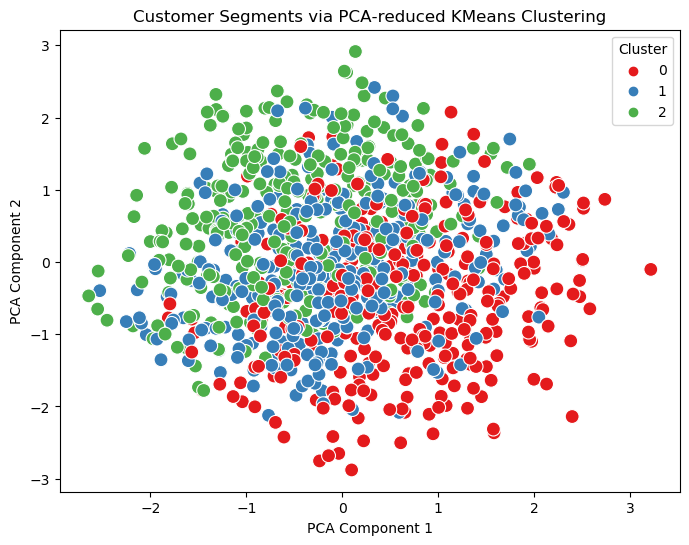

     age_of_vehicle  odometer_reading  feedback_sentiment customer_type  \
0                 6             59174               -0.40        Retail   
1                 6             32365                0.50     Corporate   
2                 5             49576               -0.15        Retail   
3                 6             83890                0.40     Corporate   
4                10             77667                0.00         Fleet   
..              ...               ...                 ...           ...   
995              10            101418                0.00        Retail   
996               9             93748                0.40     Corporate   
997               4             52739                0.00        Retail   
998              10             66442                0.00         Fleet   
999               9            101031                0.00        Retail   

    AMC_status  cluster_label  
0           No              1  
1           No              0  
2  

In [7]:
# ---- Clustering ----

# Choose number of clusters (k) - you can tune this
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_processed)

df['cluster_label'] = cluster_labels

# ---- Optional: Dimensionality reduction for visualization ----
pca = PCA(n_components=2)
components = pca.fit_transform(X_processed)

df['pca_1'] = components[:, 0]
df['pca_2'] = components[:, 1]

# ---- Output summary ----
print(f"Cluster counts:\n{df['cluster_label'].value_counts()}\n")

# Optional: show cluster centers in original feature space if desired
# To decode centers, inverse transform is needed but note one-hot encoding complicates this.

# ---- Visualization ----
plt.figure(figsize=(8,6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_label', data=df, palette='Set1', s=100)
plt.title('Customer Segments via PCA-reduced KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# ---- Example: Show clustered data ----
print(df[['age_of_vehicle', 'odometer_reading', 'feedback_sentiment', 'customer_type', 'AMC_status', 'cluster_label']])


In [8]:
# ---- Sample demo data setup (replace this with your actual data loading) ----
demo_data = {
    'age_of_vehicle': [3, 2, 4, 1, 5, 7, 2, 1, 6, 3],
    'odometer_reading': [45000, 22000, 60000, 10000, 80000, 120000, 30000, 5000, 90000, 40000],
    'last_service_cost': [5000, 4000, 6000, 3500, 4500, 7000, 3200, 2500, 6200, 4800],
    'days_since_last_service': [120, 30, 200, 45, 180, 300, 60, 40, 220, 110],
    'customer_feedback': [
        "Very satisfied with the service",
        "Poor service, delayed pickup",
        "Excellent work",
        "Good service",
        "Unresponsive staff",
        "Great experience",
        "Okay service",
        "Delayed response",
        "Happy with quick service",
        "Service could improve"
    ],
    'customer_type': ['Retail', 'Retail', 'Fleet', 'Retail', 'Fleet', 'Retail', 'Fleet', 'Retail', 'Retail', 'Fleet'],
    'AMC_status': ['Active', 'Not Subscribed', 'Active', 'Not Subscribed', 'Active', 'Active', 'Not Subscribed', 'Active', 'Active', 'Not Subscribed']
}
df = pd.DataFrame(demo_data)

In [9]:
df

,age_of_vehicle,odometer_reading,last_service_cost,days_since_last_service,customer_feedback,customer_type,AMC_status
0,3,45000,5000,120,Very satisfied with the service,Retail,Active
1,2,22000,4000,30,"Poor service, delayed pickup",Retail,Not Subscribed
2,4,60000,6000,200,Excellent work,Fleet,Active
3,1,10000,3500,45,Good service,Retail,Not Subscribed
4,5,80000,4500,180,Unresponsive staff,Fleet,Active
5,7,120000,7000,300,Great experience,Retail,Active
6,2,30000,3200,60,Okay service,Fleet,Not Subscribed
7,1,5000,2500,40,Delayed response,Retail,Active
8,6,90000,6200,220,Happy with quick service,Retail,Active
9,3,40000,4800,110,Service could improve,Fleet,Not Subscribed


In [10]:
import joblib

# Save model
joblib.dump(extract_sentiment, 'Clus_service_reminder_model.pkl')
print("Model saved as 'Clus_service_reminder_model_.pkl'")

# Later, you can load it back as:
# loaded_model = joblib.load('service_reminder_model.pkl')

Model saved as 'Clus_service_reminder_model_.pkl'
